Math 5750/6880: Mathematics of Data Science \
Project 2

# 1. Clustering Gaussian Blobs using $k$-means

In [3]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Generate 5 Gaussian blobs in 10 dimensions
X, y_true = make_blobs(
    n_samples=1000,
    centers=5,
    n_features=10,
    cluster_std=1.5,
    random_state=1)        # reproducibility
X = StandardScaler().fit_transform(X)

print(type(X),X.shape)
print(type(y_true),y_true.shape)

<class 'numpy.ndarray'> (1000, 10)
<class 'numpy.ndarray'> (1000,)


K-means inertia: 924.3159961688092


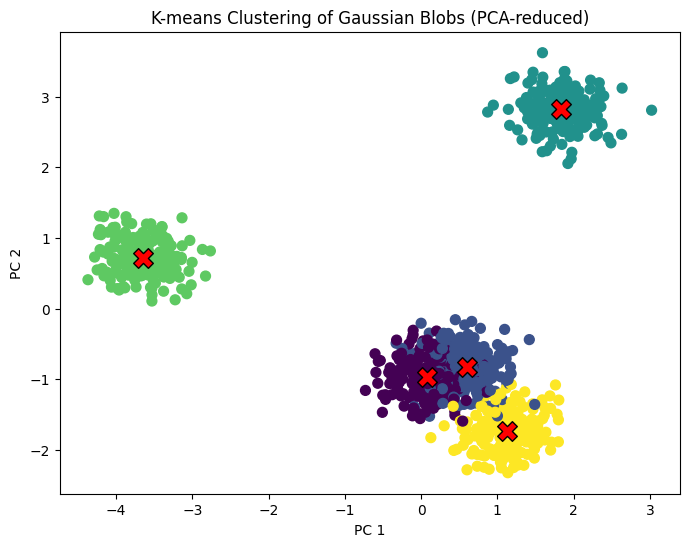

Confusion matrix after optimal label matching:
[[200   0   0   0   0]
 [  0 200   0   0   0]
 [  0   0 200   0   0]
 [  0   0   0 200   0]
 [  0   0   0   0 200]]


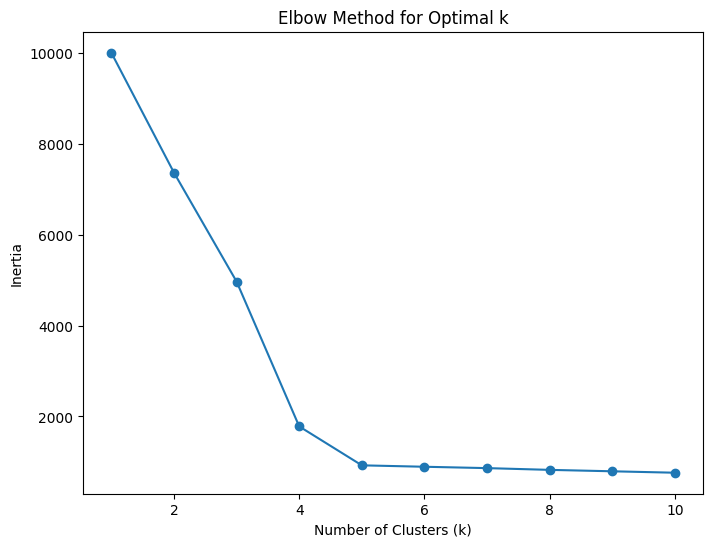

In [18]:
# your code here
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
y_kmeans = kmeans.predict(X)
print("K-means inertia:", kmeans.inertia_)

# 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
centers_pca = pca.transform(kmeans.cluster_centers_)

# Plot the results
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers_pca[:,0], centers_pca[:,1], c='red', s=200, marker='X', edgecolors='black')
plt.title('K-means Clustering of Gaussian Blobs (PCA-reduced)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

# Confusion matrix
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

# Compute confusion matrix
cm = confusion_matrix(y_true, y_kmeans)

# Hungarian algorithm (to match labels optimally)
row_ind, col_ind = linear_sum_assignment(-cm)
cm_aligned = cm[:, col_ind]

# Print the result
print("Confusion matrix after optimal label matching:")
print(cm_aligned)

# Elbow method analysis
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    inertias.append(kmeans.inertia_)

# Plot
plt.figure(figsize = (8, 6))
plt.plot(range(1,11), inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# 2. Clustering Fashion-MNIST using $k$-means

In [20]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

# Load Fashion-MNIST from OpenML
# Classes (0-9): T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
X, y = fetch_openml("Fashion-MNIST", version=1, as_frame=False, parser="auto", return_X_y=True)
y = y.astype(int)

print(type(X),X.shape)
print(type(y),y.shape)

<class 'numpy.ndarray'> (70000, 784)
<class 'numpy.ndarray'> (70000,)


K-means inertia: 297917.71008302196


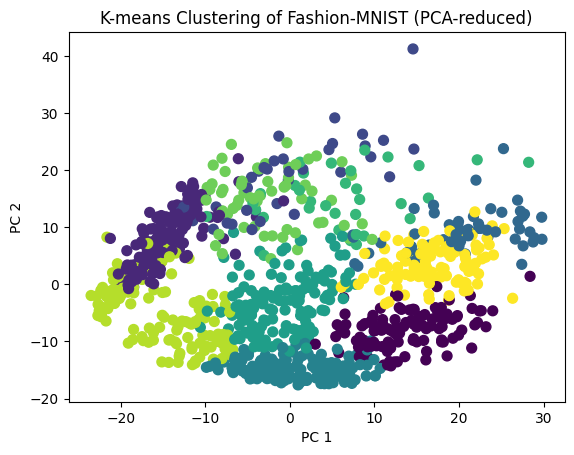

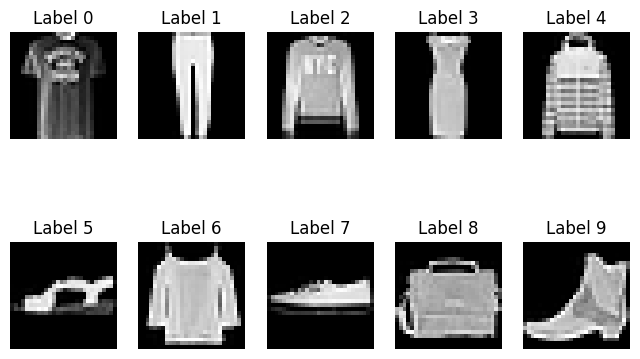

In [30]:
# your code here
# Sample smaller dataset for speed
np.random.seed(0)
idx = np.random.choice(len(X), size=1000, replace=False)
X = X[idx]
y = y[idx]

# Scale and reduce dimension
X_scaled = StandardScaler().fit_transform(X)
X_pca = PCA(n_components=50, random_state=0).fit_transform(X_scaled)

# K-means
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_pca)
y_kmeans = kmeans.predict(X_pca)
print("K-means inertia:", kmeans.inertia_)

# 2D visualization
X_2d = PCA(n_components=2, random_state=0).fit_transform(X_pca)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.title('K-means Clustering of Fashion-MNIST (PCA-reduced)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

# 10 sample images
plt.figure(figsize=(8,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X[y==i][0].reshape(28,28), cmap='gray')
    plt.title(f"Label {i}")
    plt.axis('off')
plt.show()

# 3. Dimensionality reduction for Fashion-MNIST

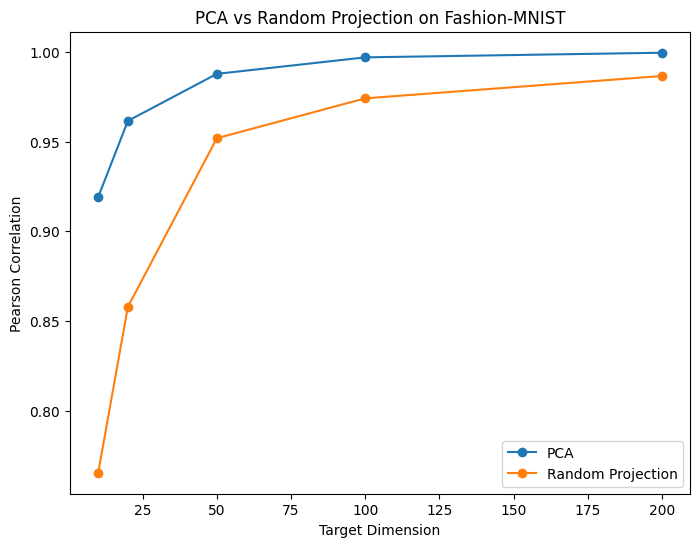

In [33]:
# your code here
from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics import pairwise_distances
from scipy.stats import pearsonr

# Load dataset
X, y = fetch_openml("Fashion-MNIST", version=1, as_frame=False, parser="auto", return_X_y=True)
y = y.astype(float)

# Sample smaller dataset for speed
np.random.seed(0)
idx = np.random.choice(len(X), size=1000, replace=False)
X = X[idx]
y = y[idx]

# Scale and reduce dimension
X_scaled = StandardScaler().fit_transform(X)

# Compute pairwise distances in original space
D_original = pairwise_distances(X_scaled)

# Target dimensions
k_values = [10, 20, 50, 100, 200]
corr_pca = []
corr_rp = []

# Compute correlations for PCA and Random Projection
for k in k_values:
    # PCA
    pca = PCA(n_components = k, random_state=0)
    X_pca = pca.fit_transform(X_scaled)
    D_pca = pairwise_distances(X_pca)
    corr_pca.append(pearsonr(D_original.flatten(), D_pca.flatten())[0])

    # Random Projection
    X_rp = GaussianRandomProjection(n_components=k, random_state=0).fit_transform(X_scaled)
    D_rp = pairwise_distances(X_rp)
    corr_rp.append(pearsonr(D_original.flatten(), D_rp.flatten())[0])

# Plot
plt.figure(figsize=(8, 6))
plt.plot(k_values, corr_pca, marker='o', label='PCA')
plt.plot(k_values, corr_rp, marker='o', label='Random Projection')
plt.xlabel('Target Dimension')
plt.ylabel('Pearson Correlation')
plt.title('PCA vs Random Projection on Fashion-MNIST')
plt.legend()
plt.show()


# 4. Clustering Fashion-MNIST using spectral clustering

ARI: 0.41658550664471494
NMI: 0.6083585677864882


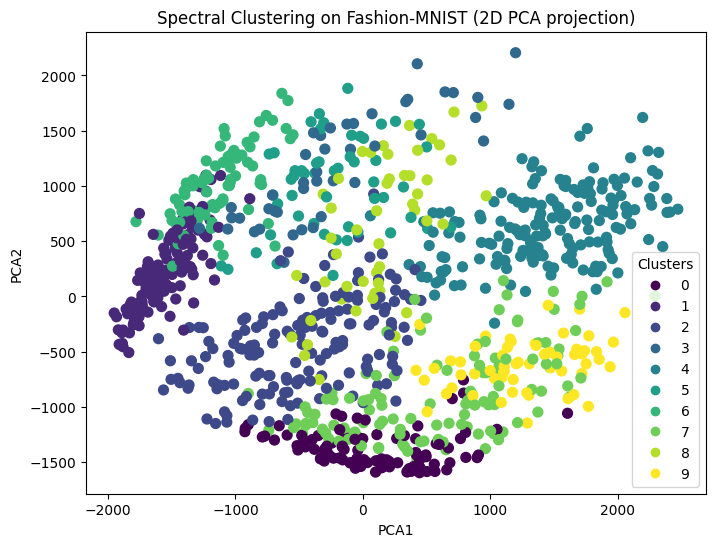

In [35]:
# your code here
from sklearn.cluster import SpectralClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Load dataset
X, y = fetch_openml("Fashion-MNIST", version=1, as_frame=False, parser="auto", return_X_y=True)
y = y.astype(int)

# Sample sunset for speed
np.random.seed(0)
idx = np.random.choice(len(X), size=1000, replace=False)
X = X[idx]
y = y[idx]

# Scale and reduce dimension
pca = PCA(n_components=50, random_state=0)
X_pca = pca.fit_transform(X)

# Spectral clustering
spectral = SpectralClustering(n_clusters=10, affinity='nearest_neighbors', random_state=0)
y_spectral = spectral.fit_predict(X_pca)

# Evaluate clustering
ari = adjusted_rand_score(y, y_spectral)
nmi = normalized_mutual_info_score(y, y_spectral)

# Print
print("ARI:", ari)
print("NMI:", nmi)

# Visualize cluster in 2D
pca_2d = PCA(n_components=2, random_state=0)
X_2d = pca_2d.fit_transform(X_pca)

# Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_spectral, s=50, cmap='viridis')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title("Spectral Clustering on Fashion-MNIST (2D PCA projection)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()
